In [1]:
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import pandas as pd
%matplotlib inline

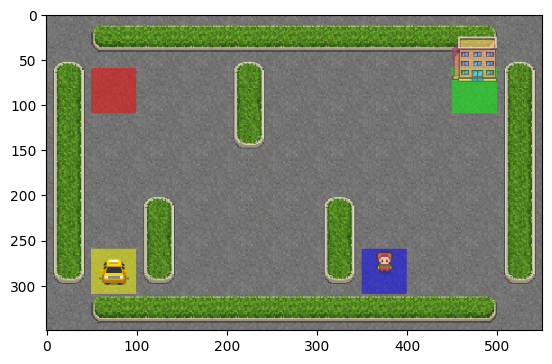

In [2]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()

plt.imshow(env.render())

In [3]:
env.close()

In [4]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

n_states=500, n_actions=6


In [5]:
next_state, reward, is_done, _, _ = env.step(1)
print(f"We got to state {next_state}, the reward is {reward}, game is not finished because is_done={is_done}")

We got to state 313, the reward is -1, game is not finished because is_done=False


In [6]:
policy = np.ones((n_states, n_actions)) / n_actions
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)
policy

array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       ...,
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667]])

In [7]:
print(n_states)

500


In [18]:
def generate_session(env, policy, t_max=int(10**4)):
    states, actions = [], []
    total_reward = 0.0
    
    s, _ = env.reset()
    
    for t in range(t_max):
        a = np.random.choice(policy.shape[1], p=policy[s])
        new_s, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        
        if done:
            break
            
    return states, actions, total_reward

In [19]:
s, a, r = generate_session(env=env, policy=policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float64]

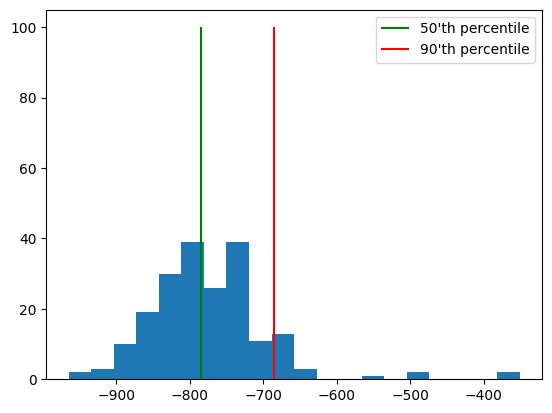

In [20]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(env=env, policy=policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

In [21]:
np.percentile(sample_rewards, 50)

-785.0

In [22]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """
    per_border = np.percentile(rewards_batch, percentile)
    elite_state=[]
    elite_action=[]
    for i in range(len(states_batch)):
        if rewards_batch[i]>=per_border:
            elite_state.extend(states_batch[i])
            elite_action.extend(actions_batch[i])
            
    return elite_state,elite_action

In [23]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=0)
test_result_40 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
    and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
    "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
    np.all(test_result_40[1] == [3, 2, 0, 1, 3, 3]),\
    "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and \
    np.all(test_result_90[1] == [3, 3]),\
    "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and\
    np.all(test_result_100[1] == [3, 3]),\
    "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [25]:
def update_policy(elite_states, elite_actions, n_states=n_states, n_actions=n_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]

    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """
    new_policy = np.zeros((n_states, n_actions))

    for state, action in zip(elite_states, elite_actions):
        new_policy[state, action] += 1

    for state in range(n_states):
        state_count = new_policy[state].sum()
        if state_count == 0:
            new_policy[state] = np.ones(n_actions) / n_actions
        else:
            new_policy[state] /= state_count

    return new_policy


In [26]:
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]

new_policy = update_policy(elite_states, elite_actions)

assert np.isfinite(new_policy).all(
), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(
    new_policy >= 0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(
    axis=-1), 1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
    [1.,  0.,  0.,  0.,  0.],
    [0.5,  0.,  0.,  0.5,  0.],
    [0.,  0.33333333,  0.66666667,  0.,  0.],
    [0.,  0.,  0.,  0.5,  0.5]])
assert np.allclose(new_policy[:4, :5], reference_answer)
print("Ok!")

Ok!


In [27]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [28]:
# reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions

mean reward = -40.944, threshold=-33.000


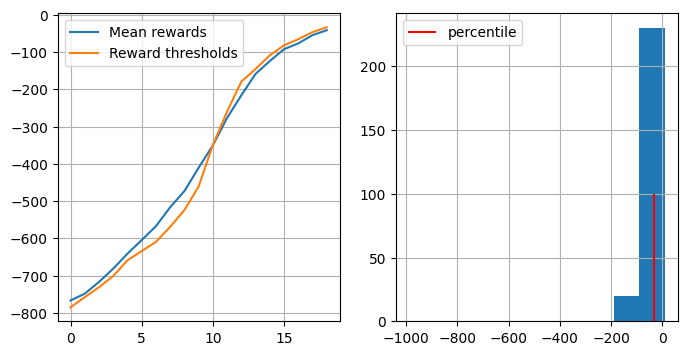

You Win!


In [29]:
n_sessions = 250
percentile = 50
learning_rate = 0.5

log = []

for i in range(100):
    # УБИРАЕМ %time и ДОБАВЛЯЕМ env
    sessions = [generate_session(env, policy) for _ in range(n_sessions)]
    
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    # Убедимся, что передаем n_states и n_actions
    new_policy = update_policy(elite_states, elite_actions, n_states, n_actions)
    
    policy = learning_rate * new_policy + (1 - learning_rate) * policy
    
    show_progress(rewards_batch, log, percentile)
    
    if np.mean(rewards_batch) > -50:
        print("You Win!")
        break